In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import style
import pandas as pd
from tqdm.auto import tqdm, trange
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

DIR = os.getcwd()

Running on the GPU


In [5]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-a9955c28-f9fc-7a9e-2798-2ec614353340)


In [6]:
print(DIR)

/content


In [7]:
BATCH_SIZE = 64
EPOCHS = 10
PIXELS = 128
nc = 3 # Number of color channels
d_dim = 200 # Length of latent Vector (nz)

In [8]:

! pip install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d greg115/album-covers-images

! mkdir train
! unzip album-covers-images.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/album_covers_512/77259.jpg  
  inflating: train/album_covers_512/7726.jpg  
  inflating: train/album_covers_512/77260.jpg  
  inflating: train/album_covers_512/77261.jpg  
  inflating: train/album_covers_512/77262.jpg  
  inflating: train/album_covers_512/77263.jpg  
  inflating: train/album_covers_512/77264.jpg  
  inflating: train/album_covers_512/77265.jpg  
  inflating: train/album_covers_512/77266.jpg  
  inflating: train/album_covers_512/77267.jpg  
  inflating: train/album_covers_512/77268.jpg  
  inflating: train/album_covers_512/77269.jpg  
  inflating: train/album_covers_512/7727.jpg  
  inflating: train/album_covers_512/77270.jpg  
  inflating: train/album_covers_512/77271.jpg  
  inflating: train/album_covers_512/77272.jpg  
  inflating: train/album_covers_512/77273.jpg  
  inflating: train/album_covers_512/77274.jpg  
  inflating: train/album_covers_512/77275.jpg  
  inflating: train/album_covers_512/772

In [9]:
class ImageFolderEX(datasets.ImageFolder):
    def __getitem__(self, index):
        def get_img(index):
            path, label = self.imgs[index]
            try:
                img = self.loader(os.path.join(self.root, path))
            except:
                img = get_img(index + 1)
            return img
        img = get_img(index)
        return self.transform(img) * 2 - 1  # rescale 0 - 1 to -1 - 1

trans = transforms.Compose([
    transforms.Resize((PIXELS, PIXELS), interpolation=2), 
    transforms.ToTensor(), # implicitly normalizes the input to values between 0 - 1.
])

training_data = torch.utils.data.DataLoader(ImageFolderEX(f"{DIR}/train/", trans), 
	                                          batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=0)
x = next(iter(training_data))

In [10]:

def Data2Img(x):
  new = torch.zeros(x.size(0), PIXELS, PIXELS, 3)
  
  for i in range(x.size(0)):
    new[i] = torch.transpose(torch.transpose(x[i], 0, 1), 1, 2)
  
  return new

# plt.imshow(Data2Img(x)[3])

In [11]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()  

    kernel_size = 4
    padding = 1
    stride = 2
    alpha = 0.2
    size = 4 * 4 * 1024
    
    # https://www.ritchievink.com/blog/2018/07/16/generative-adversarial-networks-in-pytorch-the-distribution-of-art/
    # We take a vector of d_dim -> to length of 4 * 4 * 1024;
    # This will become a 4 x 4 image with 1024 channels, for which we insert into network
    # We blow up the image to 128 x 128 with 3 channels. 

    self.input = nn.Linear(d_dim, size)
    self.net = nn.Sequential(
      nn.BatchNorm2d(1024),
      nn.LeakyReLU(alpha),
      nn.ConvTranspose2d(1024, 512, kernel_size, stride, padding),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(alpha),
      nn.ConvTranspose2d(512, 512, kernel_size, stride, padding),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(alpha),
      nn.ConvTranspose2d(512, 256, kernel_size, stride, padding),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(alpha),
      nn.ConvTranspose2d(256, 128, kernel_size, stride, padding),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(alpha),
      nn.ConvTranspose2d(128, 3, kernel_size, stride, padding),
      nn.Tanh()
    )
  
  def forward(self, z):
    x = self.input(z)
    # Note that this outputs an image with values -1 -> 1; we will 
    # need to make sure to scale to 256 after
    return self.net(x.view(-1, 1024, 4, 4))

def GenView():  
  print("Generators's Info")
  genInput = torch.randn(BATCH_SIZE, d_dim)
  print(f"Input Size: {genInput.size()}")
  testGen = Generator()
  output = testGen(genInput)
  print(f"Output Size: {output.size()}")

GenView()

Generators's Info
Input Size: torch.Size([64, 200])
Output Size: torch.Size([64, 3, 128, 128])


In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        kernel_size = 4
        padding = 1
        stride = 2
        alpha = 0.2

        # Note that due to our generators outputs, we will need to make sure real
        # images are scaled properly.
        
        self.net = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Conv2d(128, 256, kernel_size, stride, padding),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(alpha),
            nn.Conv2d(256, 512, kernel_size, stride, padding),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 512, kernel_size, stride, padding),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 1024, kernel_size, stride, padding),
            nn.InstanceNorm2d(1024, affine=True),
            nn.LeakyReLU(alpha),
        )
        self.output = nn.Linear(4 * 4 * 1024, 1)
        
    def forward(self, x):
        x = self.net(x)
        # The net downsizes 128 x 128 by stride = 2 every layer -> 4 x 4 with 
        # 1024 channels
        x = torch.reshape(x, (-1, 4 * 4 * 1024))
        x = self.output(x)
        
        return x

def DiscView():
  print("Discriminator's Info")
  discInput = torch.randn(BATCH_SIZE, 3, PIXELS, PIXELS)
  print(f"Input Size: {discInput.size()}")
  testDisc = Discriminator()
  output = testDisc(discInput)
  print(f"Output Size: {output.size()}")

DiscView()


Discriminator's Info
Input Size: torch.Size([64, 3, 128, 128])
Output Size: torch.Size([64, 1])


In [13]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device(device))
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    return model

# D = load_checkpoint('./gdrive/MyDrive/wcheckpointD.pth').to(device)
# G = load_checkpoint('./gdrive/MyDrive/wcheckpointG.pth').to(device)

In [14]:
G = Generator().to(device)
D = Discriminator().to(device)

In [15]:
print(G)
print(D)

Generator(
  (input): Linear(in_features=200, out_features=16384, bias=True)
  (net): Sequential(
    (0): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, 

In [16]:
# optimizer
lr = 1e-4
beta = (0.0,0.9)

def load_optim(filepath, net, lr,beta):
    checkpoint = torch.load(filepath)
    myOpt = optim.Adam(net.parameters(), lr = lr, betas=beta)
    myOpt.load_state_dict(checkpoint['optimizer'])
    return myOpt

# D_optimizer = load_optim('./gdrive/My Drive/wcheckpointD.pth', D, lr, beta)
# G_optimizer = load_optim('./gdrive/My Drive/wcheckpointG.pth', G, lr, beta)

In [17]:
# optimizer
lr = 1e-4
beta = (0.0,0.9)

G_optimizer = optim.Adam(G.parameters(), lr = lr, betas=beta)
D_optimizer = optim.Adam(D.parameters(), lr = lr, betas=beta)

In [18]:
def gradient_penalty(critic, real, fake, device="cpu"):
  BATCHSIZE, C, H, W = real.shape
  epsilon = torch.rand((BATCHSIZE,1,1,1)).repeat(1,C,H,W).to(device)
  # Interpolating real and fake image with random epsilon per image
  interpolated_images = real * epsilon + fake * (1 - epsilon)

  # Calculate critic scores
  mixed_score = D(interpolated_images)

  # Gradient of mixed score in respect to the interpolated images
  gradient = torch.autograd.grad(
      inputs=interpolated_images,
      outputs=mixed_score,
      grad_outputs=torch.ones_like(mixed_score),
      create_graph=True,
      retain_graph=True,
  )[0]

  # Flatten the gradient
  gradient = gradient.view(gradient.shape[0],-1)
  # Take the L2 Norm
  gradient_norm = gradient.norm(2,dim=1)
  gradient_penalty = torch.mean((gradient_norm-1)**2)
  return gradient_penalty

LAMBDA_GP = 10

In [19]:
def D_train(x):
  D_optimizer.zero_grad()

  # Creating inputs of real data
  realX, realY = x.to(device), torch.ones(x.size(0), 1).to(device)
  D_real_output = D(realX)
  
  # Creating inputs of generated data
  z = torch.randn(x.size(0),d_dim).to(device)
  fakeX, fakeY = G(z), torch.zeros(x.size(0), 1).to(device)
  D_fake_output = D(fakeX.detach())
  D_fake_output = D_fake_output.view(x.size(0), 1)
  
  # Gradient Penalty
  gp = gradient_penalty(D,realX, fakeX, device)

  # Take the average
  D_loss = -torch.mean(D_real_output) + torch.mean(D_fake_output) + LAMBDA_GP * gp
  D_loss.backward(retain_graph=True)
  D_optimizer.step()     

  # print("D ", D_loss.item())
  return D_loss.item(), x.size(0)

In [20]:
def G_train(size):
  G_optimizer.zero_grad()

  # Is this consider a random distribution?
  z = torch.randn(size,d_dim).to(device)
  # We want the Discriminator to think this is all real data
  y = torch.ones(size, 1).to(device)

  G_output = G(z)
  D_output = D(G_output)
  D_output = D_output.view(size, 1)
  G_loss = -torch.mean(D_output)
  
  G_loss.backward()
  G_optimizer.step()
  
  # print("G ", G_loss.item())
  return G_loss.item()

In [21]:
def view_G():
  with torch.no_grad():
    test_z = torch.randn(BATCH_SIZE,d_dim).to(device)
    generate = G(test_z)
    return (Data2Img(generate)[0] + 1) / 2

# plt.imshow(view_G())

In [22]:
def save():
  path = "/content/gdrive/MyDrive/" 
  checkpointG = {'model': Generator(),
              'state_dict': G.state_dict(),
              'optimizer' : G_optimizer.state_dict()}
  torch.save(checkpointG, path + 'wcheckpointG.pth')
  checkpointD = {'model': Discriminator(),
              'state_dict': D.state_dict(),
              'optimizer' : D_optimizer.state_dict()}
  torch.save(checkpointD, path + 'wcheckpointD.pth')

def saveArrays():
  # Save the Tracked Data
  path = "/content/gdrive/MyDrive/"
  np.save(path + "d_loss.npy", np.array(epoch_d))
  np.save(path + "g_loss.npy", np.array(epoch_g))

save()

In [23]:
def plotData(d_data, g_data):
  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1), (0,0))
  ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
  
  ax1.plot(range(len(d_data)), d_data, label="Discriminator's Loss")
  ax1.legend(loc=2)
  ax2.plot(range(len(g_data)), g_data, label="Generator's Loss")
  ax2.legend(loc=2)
  plt.xlabel("Training Iteration")
  plt.ylabel("Loss Values")
  
  plt.show()

In [24]:
path = "/content/gdrive/MyDrive/"
# epoch_d = np.load(path + "d_loss.npy", allow_pickle=True)
# epoch_g = np.load(path + "g_loss.npy", allow_pickle=True)
# saveArrays()

In [25]:
epoch_d = np.array([])
epoch_g = np.array([])
saveArrays()

In [26]:
for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs Progress"):
  D_losses, G_losses = [], []
  count = 0
  for batch_idx, x in tqdm(enumerate(training_data), desc="Batch Progress"):
    if count == 400:
      count = 0
      epoch_d = np.append(epoch_d, torch.mean(torch.FloatTensor(D_losses[-400:])))
      epoch_g = np.append(epoch_g, torch.mean(torch.FloatTensor(G_losses[-80:])))
      save()
      saveArrays()
    val, size = D_train(x)
    D_losses.append(val) 
    if batch_idx % 5 == 0:
      G_losses.append(G_train(size)) 
    count += 1   
    
  d_mean = torch.mean(torch.FloatTensor(D_losses))
  g_mean = torch.mean(torch.FloatTensor(G_losses))
  epoch_d = np.append(epoch_d, d_mean)
  epoch_g = np.append(epoch_g, g_mean)
  print(f"Epoch: {epoch} | D_loss: {d_mean} | G_loss: {g_mean}")
  save()     
  saveArrays()

Epochs Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Batch Progress: 0it [00:00, ?it/s]

Epoch: 1 | D_loss: -89.357666015625 | G_loss: 124.70852661132812


Batch Progress: 0it [00:00, ?it/s]

Epoch: 2 | D_loss: -72.13554382324219 | G_loss: 169.8197784423828


Batch Progress: 0it [00:00, ?it/s]

Epoch: 3 | D_loss: -65.06401062011719 | G_loss: 168.94642639160156


Batch Progress: 0it [00:00, ?it/s]

Epoch: 4 | D_loss: -64.7664566040039 | G_loss: 184.84617614746094


Batch Progress: 0it [00:00, ?it/s]

Epoch: 5 | D_loss: -66.07998657226562 | G_loss: 180.54441833496094


Batch Progress: 0it [00:00, ?it/s]

Epoch: 6 | D_loss: -63.70444869995117 | G_loss: 182.0196533203125


Batch Progress: 0it [00:00, ?it/s]

Epoch: 7 | D_loss: -59.04494094848633 | G_loss: 173.02484130859375


Batch Progress: 0it [00:00, ?it/s]

Epoch: 8 | D_loss: -56.749267578125 | G_loss: 163.88633728027344


Batch Progress: 0it [00:00, ?it/s]

Epoch: 9 | D_loss: -56.00078582763672 | G_loss: 163.22886657714844


Batch Progress: 0it [00:00, ?it/s]

Epoch: 10 | D_loss: -53.70714569091797 | G_loss: 161.8609161376953


40
40


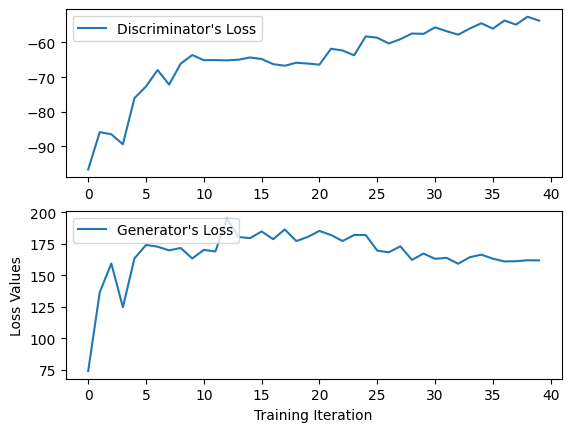

In [27]:

print(len(epoch_d))
print(len(epoch_g))
plotData(epoch_d, epoch_g)

Drawing Generated Images:   0%|          | 0/16 [00:00<?, ?it/s]

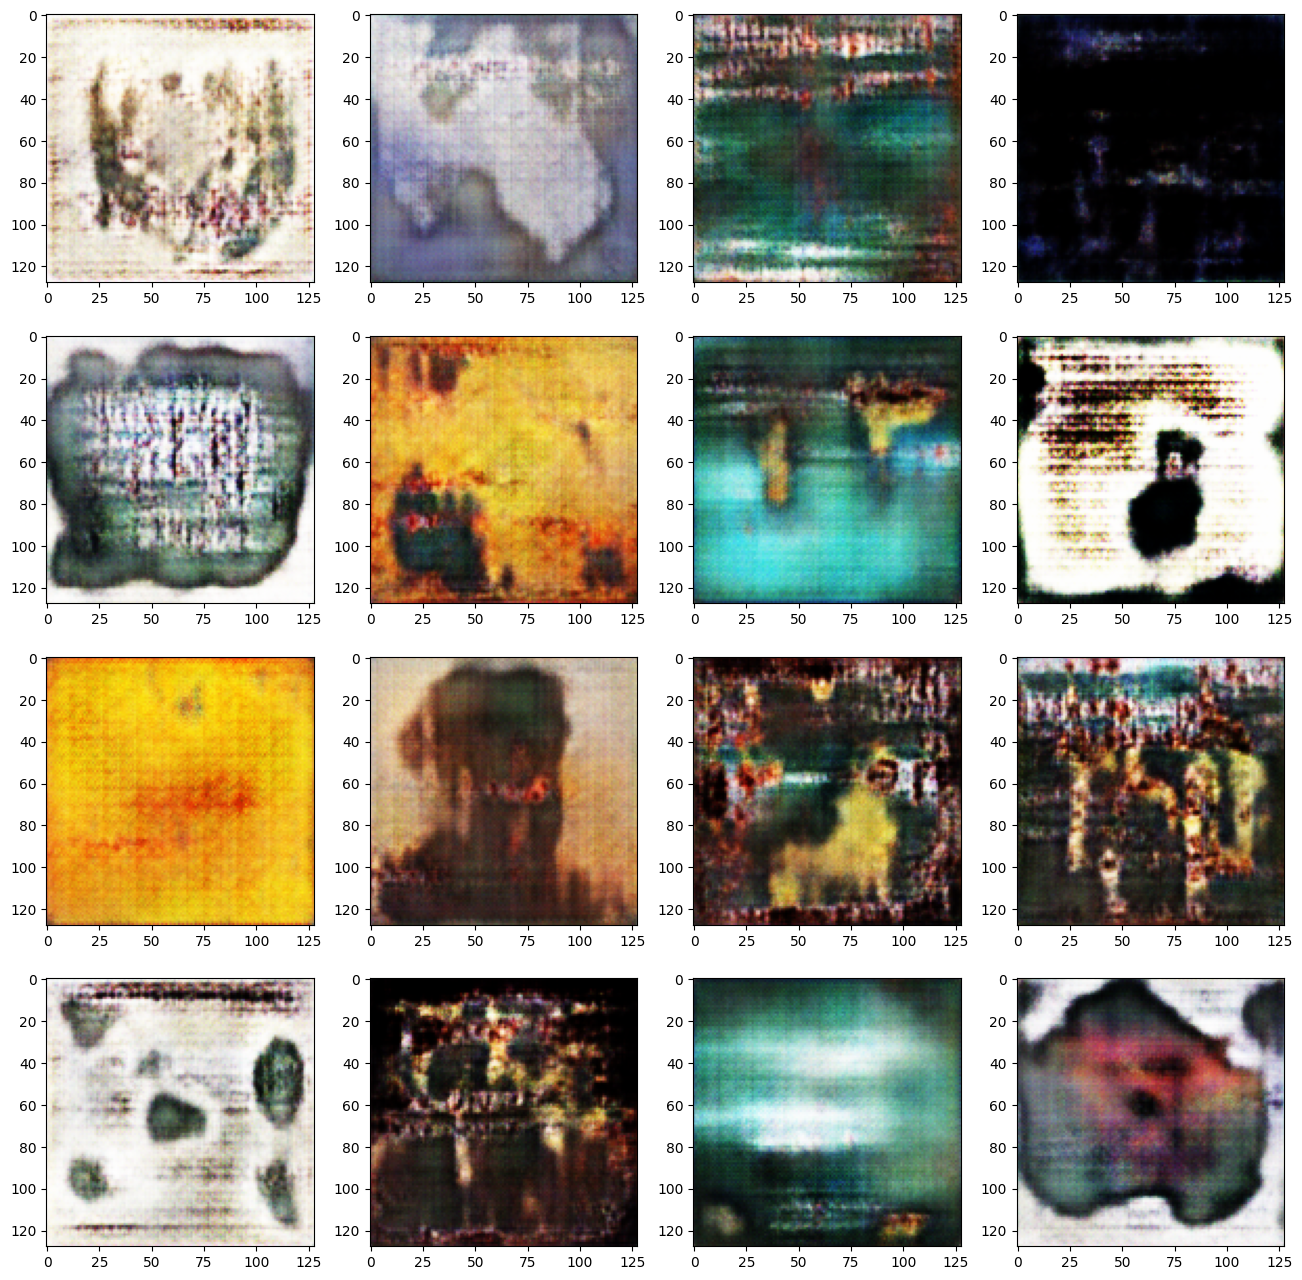

In [30]:

def sampleData():
  lister = []
  for i in range(16):
    lister.append(view_G())
  return lister
 
sample = sampleData()
fig=plt.figure(figsize=(16,16)) 
columns = 4 
rows = 4
for i in tqdm(range(1, columns*rows +1), desc="Drawing Generated Images"):
    fig.add_subplot(rows, columns, i)
    plt.imshow(sample[i-1])  
plt.show()